<a href="https://colab.research.google.com/github/MutantLeech/CRE-Project/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# Giant pre-preprocessing cell
# I fully expect this to take like a full hour, this has literally 47,000,000 lines and it's gotta go line by line (Update: 7m15s. python do be data processing)
import regex as r

# Pack these collections of games into dictionaries for easier processing
def dict_pack(game):
    tag_regex = r"\[(.*?) \"(.*?)\"\]"
    said_dict = {}

    for line in game:
        possible_match = r.match(tag_regex, line)
        if possible_match:
            said_dict[possible_match.group(1)] = possible_match.group(2)
        elif line != "\n":
            said_dict["Moves"] = line

    return said_dict

# We only want certain kinds of games for this task
def accept_or_reject(game_dict: dict):
    # print(game_dict)
    # Criteria for acceptance
    # Not some random chess variant (i.e. regular chess)
    if "Variant" in game_dict:
        return False
    # Ended normally
    if game_dict["Termination"] != "Normal":
        # print("abnormal termination: " + game_dict["Termination"])
        return False
    # Decisively ended (although I'll leave code for including draws)
    # if game_dict["Result"] not in ["1-0", "0-1, 1/2-1/2"]:
    if game_dict["Result"] not in ["1-0", "0-1"]:
        # print("abnormal result: " + game_dict["Result"])
        return False
    # Has the ELO ratings we're looking for
    if not ("WhiteElo" in game_dict and "BlackElo" in game_dict):
        # print("missing ELO ratings")
        return False

    # Passes all those checks, so we're good
    # print("check")
    return True

# Okay, now for the actual file processing
# Don't worry, .pgn files are just plaintext files, just with a special extension
file_name = r"lichess_db_standard_rated_2015-08.pgn" # If you've got another file, you can replace this
new_file_name = f"{file_name[:-4]}_clean.pgn"
# GAME_LIMIT = 50 # I want to test this out, so this means that only this many games get parsed

# Open both the original file and the new file
# This will close both files once it's done
skip_this_blank = True
with open("datafiles/" + file_name, "r") as FILE, open("datafiles/" + new_file_name, "w") as NEW_FILE:
    current_game = []
    i = 0
    for line in FILE:
        if line != "\n":
            current_game.append(line)
            continue
        elif skip_this_blank:
            skip_this_blank = not skip_this_blank
            continue
        
        game_dict = dict_pack(current_game)
        if accept_or_reject(game_dict):
            NEW_FILE.write("".join(current_game))
            NEW_FILE.write("\n") # Gotta double newline so they're separated by blank lines
        current_game.clear()
        skip_this_blank = True

        i += 1
        # if i > GAME_LIMIT: break

In [ ]:
# Now we can do actual preprocessing to turn these into usable data
# Still using the functions from the last one though, no need to recycle them
import numpy as np

# Put two versions of each game into the pool, one for white and one for black
# If false, only white's version is added
DOUBLE_GAMES = True

# In the form [ELO, number of moves, result for white]
# TODO: Write this to a file, probably
chess_data = []

with open("datafiles/" + new_file_name) as FILE:
    current_game = []
    i = 0

    for line in FILE:
        if line != "\n":
            current_game.append(line)
            continue
        
        game_dict = dict_pack(current_game)
        white_rating = game_dict["WhiteElo"]
        game_moves_split = game_dict["Moves"].split(" ")
        move_length = np.ceil((len(game_moves_split) - 1) / 3) # Moves are three units long, -1 to remove the result at the end
        result = ["0-1", "1/2-1/2", "1-0"].index(game_dict["Result"]) / 2 # returns 0, 0.5, or 1

        chess_data.append([white_rating, move_length, result])

        if DOUBLE_GAMES:
            black_rating = game_dict["BlackElo"]

            chess_data.append([black_rating, move_length, result])

        current_game.clear()
        i += 1
        # if i > 10: break

chess_data = np.array(chess_data)
# print(chess_data[0:10])



87 29.0
69 23.0
121 40.0
69 23.0
81 27.0
16 5.0
187 62.0
165 55.0
121 40.0
63 21.0
121 40.0
[['1509' '28' '1.0']
 ['1623' '28' '1.0']
 ['1857' '22' '1.0']
 ['1963' '22' '1.0']
 ['892' '40' '0.0']
 ['1345' '40' '0.0']
 ['1953' '22' '1.0']
 ['1872' '22' '1.0']
 ['1358' '26' '1.0']
 ['1541' '26' '1.0']]


Clusters: [0 0 0 2 1 1 2]
Silhouette Score: 0.4177943585835489


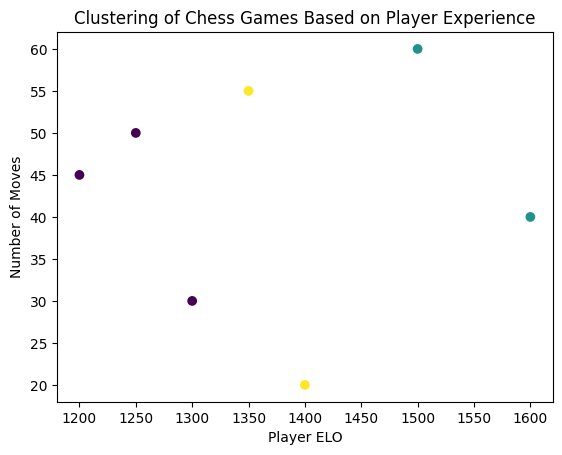

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Example data: [player_elo, num_moves, result]
chess_data = np.array([
    [1200, 45, 1],
    [1300, 30, 0],
    [1250, 50, 1],
    [1400, 20, 0],
    [1500, 60, 1],
    [1600, 40, 1],
    [1350, 55, 0]
])

# Number of clusters
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(chess_data)

# Assigning each game a cluster
print("Clusters:", clusters)

# Evaluating the clustering
silhouette_avg = silhouette_score(chess_data, clusters)
print("Silhouette Score:", silhouette_avg)

# Visualize the clustering
plt.scatter(chess_data[:, 0], chess_data[:, 1], c=clusters, cmap='viridis')
plt.xlabel('Player ELO')
plt.ylabel('Number of Moves')
plt.title('Clustering of Chess Games Based on Player Experience')
plt.show()

